# MS019 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS019'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS019/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [7]:
mne_data

<RawEDF | MS019_SWB.edf, 276 x 2176000 (2125.0 s), ~4.47 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'C63',
 'C64',
 'LsPpC1',
 'LsPpC2',
 'LsPpC3',
 'LsPpC4',
 'LsPpC5',
 'LsPpC6',
 'LsPpC7',
 'LsPpC8',
 'LsPpC9',
 'LsPpC10',
 'LsPpC11',
 'LsPpC12',
 'RsPpC1',
 'RsPpC2',
 'RsPpC3',
 'RsPpC4',
 'RsPpC5',
 'RsPpC6',
 'RsPpC7',
 'RsPpC8',
 'RsPpC9',
 'RsPpC10',
 'RsPpC11',
 'RsPpC12',
 'LilTO1',
 'LilTO2',
 '

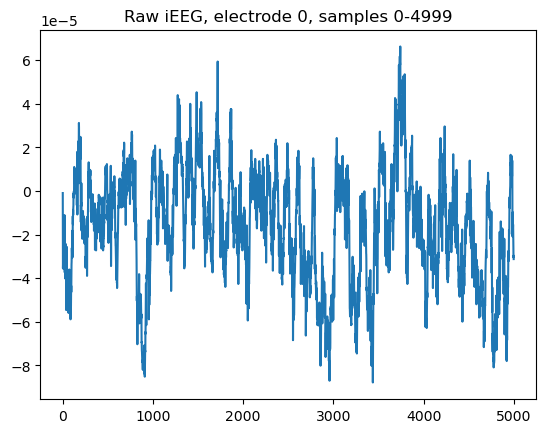

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

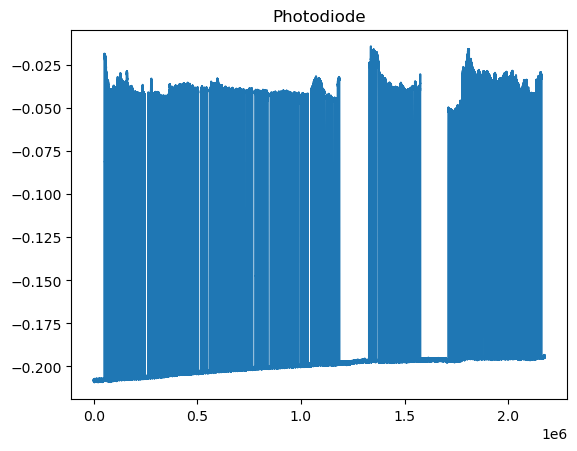

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
ms019_anat_file = glob(f'{anat_dir}/MS019_labels.csv')[0]
elec_locs = pd.read_csv(ms019_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -2.795636  34.346371   5.999996  -2.570422   
1    LaCaS10      A9l_L -11.581916  56.312073  43.999994 -12.306464   
2    LaCaS11    Unknown -12.380669  59.107707  48.399994 -13.320612   
3    LaCaS12    Unknown -13.179422  60.305837  51.199993 -14.276922   
4     LaCaS2    A32sg_L  -3.594388  36.742630   9.999996  -3.429509   
..       ...        ...        ...        ...        ...        ...   
167   RsPpC7     A7ip_R  25.160712 -45.129531  35.999994  26.390526   
168   RsPpC8     A7ip_R  28.755099 -47.525789  39.199994  30.549717   
169   RsPpC9     A7ip_R  32.349487 -49.522671  41.999994  34.673166   
170   uLmOIF      A13_L  -4.792518  37.940759  -4.800003  -4.177642   
171   uRmOIF     A14m_R   5.591269  38.340135  -0.400004   7.420068   

         mni_y      mni_z       gm                                 NMM  \
0    27.802347  -5.413951     Gray  Left ACgG anterior cingulate gyrus   
1    60.493542  33.029109     Gray     Left SFG superior frontal gyrus   
2    64.809729  37.490489  Unknown                             Unknown   
3    66.898697  40.415833  Unknown                             Unknown   
4    31.395072  -1.489375     Gray  Left ACgG anterior cingulate gyrus   
..         ...        ...      ...                                 ...   
167 -50.717179  46.775628     Gray  Right SPL superior parietal lobule   
168 -52.507090  50.966902     Gray  Right SPL superior parietal lobule   
169 -54.045856  54.610691     Gray  Right SPL superior parietal lobule   
170  28.423886 -18.311256     Gray      Left MFC medial frontal cortex   
171  30.214405 -13.403811     Gray     Right MFC medial frontal cortex   

                Anat                   AnatMacro    BN246  \
0           Area s24                       L ACC     L CG   
1            Unknown    L Superior Frontal Gyrus    L SFG   
2            Unknown                     Unknown  Unknown   
3            Unknown                     Unknown  Unknown   
4            Area 33                       L ACC     L CG   
..               ...                         ...      ...   
167          Unknown                     Unknown    R SPL   
168  Area hIP3 (IPS)  R Inferior Parietal Lobule    R SPL   
169  Area hIP3 (IPS)  R Inferior Parietal Lobule    R SPL   
170         Area s32              L Rectal Gyrus    L OrG   
171         Area s32         R Mid Orbital Gyrus    R OrG   

                               YBA_1 Manual Examination Notes  
0             Left cingulate gyrus C                NaN   NaN  
1    Left superior frontal gyrus 1 D                NaN   NaN  
2                            Unknown                OOB   NaN  
3                            Unknown                OOB   NaN  
4             Left cingulate gyrus D                NaN   NaN  
..                               ...                ...   ...  
167      Right superior parietal 2 D                 WM   NaN  
168      Right superior parietal 2 D                NaN   NaN  
169      Right superior parietal 2 D                NaN   NaN  
170            Left frontal pole 1 B                NaN   NaN  
171           Right frontal pole 1 B                NaN   NaN  

[172 rows x 16 columns]

In [12]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT10',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LiITO1',
 'LiITO2',
 'LiITO3',
 'LiITO4',
 'LiITO5',
 'LiITO6',
 'LiITO7',
 'LiITO8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIOC1',
 'LpIOC10',
 'LpIOC11',
 'LpIOC12',
 'LpIOC13',
 'LpIOC14',
 'LpIOC2',
 'LpIOC3',
 'LpIOC4',
 'LpIOC5',
 'LpIOC6',
 'LpIOC7',
 'LpIOC8',
 'LpIOC9',
 'LsPpC1',
 'LsPpC10',
 'LsPpC11',
 'LsPpC12',
 'LsPpC2',
 'LsPpC3',
 'LsPpC4',
 'LsPpC5',
 'LsPpC6',
 'LsPpC7',
 'LsPpC8',
 'LsPpC9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'Ra

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [14]:
unmatched_names

['urmoif', 'ulmoif']

In [20]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict

{'lmoif1': 'lmoif1',
 'lmoif2': 'lmoif2',
 'lmoif3': 'lmoif3',
 'lmoif4': 'lmoif4',
 'lmoif5': 'lmoif5',
 'lmoif6': 'lmoif6',
 'lmoif7': 'lmoif7',
 'lmoif8': 'lmoif8',
 'lmoif9': 'lmoif9',
 'rmoif1': 'rmoif1',
 'rmoif2': 'rmoif2',
 'rmoif3': 'rmoif3',
 'rmoif4': 'rmoif4',
 'rmoif5': 'rmoif5',
 'rmoif6': 'rmoif6',
 'rmoif7': 'rmoif7',
 'rmoif8': 'rmoif8',
 'rmoif9': 'rmoif9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 

In [19]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

ValueError: Invalid channel name(s) {'RmCmS4', 'LmCmS4', 'T5', 'RaCaS8', 'RsPpC2', 'LHplT6', 'RaCaS4', 'C240', 'RaCaS2', 'DC11', 'P4', 'Fp2', 'RmOlF4', 'PR', 'C242', 'RAglT9', 'LaCaS7', 'C241', 'LAglT9', 'C255', 'RaCaS3', 'LHplT1', 'RAglT3', 'RmCmS6', 'DC9', 'C251', 'LAglT5', 'LsPpC10', 'C250', 'RilTO3', 'C220', 'RmCmS9', 'LaCaS2', 'RmOlF6', 'RsPpC4', 'LAglT1', 'LmCmS10', 'LaCaS12', 'DC2', 'RplOc9', 'C235', 'C229', 'LHplT5', 'C218', 'RmCmS8', 'RplOc7', 'C230', 'RmOlF3', 'DC4', 'RsPpC3', 'DC7', 'T4', 'LAglT8', 'C248', 'RmCmS7', 'LmOlF1', 'C219', 'C252', 'RAglT10', 'RmOlF9', 'RHplT7', 'LmOlF8', 'LplOc13', 'RsPpC8', 'LAglT3', 'F3', 'C221', 'LsPpC7', 'C247', 'C244', 'LmOlF5', 'C249', 'LplOc8', 'LmCmS1', 'RAglT1', 'C222', 'RplOc11', 'C237', 'LplOc9', 'LmCmS7', 'LsPpC4', 'LmCmS5', 'LmOlF3', 'O1', 'RmOlF2', 'RsPpC12', 'RaCaS9', 'LHplT8', 'LsPpC12', 'RHplT9', 'C239', 'LHplT10', 'RaCaS5', 'C211', 'EKG1', 'RaCaS6', 'ABS1', 'RilTO4', 'DC10', 'LmCmS9', 'RmCmS2', 'LmCmS3', 'RHplT4', 'C225', 'C212', 'F8', 'RplOc13', 'RaCaS12', 'LAglT6', 'ABS2', 'RplOc5', 'LsPpC3', 'LilTO4', 'RplOc8', 'LsPpC11', 'RAglT7', 'LmOlF9', 'LilTO7', 'LHplT2', 'LplOc1', 'O2', 'Pz', 'C226', 'RilTO7', 'LAglT4', 'TRIG', 'RmOlF8', 'C127', 'C233', 'C205', 'LaCaS11', 'RaCaS7', 'LplOc5', 'DC6', 'C209', 'LmOlF4', 'LplOc14', 'CHEST 2', 'C231', 'LmCmS6', 'RAglT4', 'RplOc6', 'C256', 'LmOlF2', 'LsPpC6', 'LsPpC5', 'LplOc4', 'RaCaS10', 'DC3', 'DC15', 'C224', 'C217', 'LaCaS3', 'C206', 'RilTO6', 'DC1', 'LilTO2', 'C214', 'C202', 'RilTO5', 'RilTO8', 'LplOc6', 'C246', 'LaCaS6', 'RHplT2', 'RmOlF1', 'RsPpC9', 'DC8', 'C232', 'LilTO1', 'DC13', 'LaCaS5', 'LaCaS10', 'C243', 'LmOlF6', 'RilTO1', 'T6', 'RAglT2', 'RHplT3', 'LAglT2', 'LilTO3', 'LaCaS4', 'LilTO8', 'C4', 'LilTO6', 'RHplT6', 'LilTO5', 'LplOc11', 'C228', 'C210', 'C223', 'LaCaS9', 'LplOc10', 'C238', 'DC16', 'C64', 'C204', 'C208', 'DC12', 'RplOc3', 'RsPpC11', 'RplOc1', 'C253', 'Fp1', 'EKG2', 'RmCmS1', 'RAglT5', 'C63', 'LAglT7', 'LsPpC9', 'Pleth', 'Fz', 'CHEST 1', 'RHplT5', 'DC14', 'LsPpC1', 'RHplT8', 'RmOlF5', 'C126', 'C234', 'RsPpC1', 'RsPpC6', 'RplOc12', 'RaCaS1', 'LmCmS8', 'C3', 'LAglT10', 'RsPpC10', 'C125', 'LHplT3', 'LplOc2', 'LmCmS2', 'C128', 'RplOc10', 'P3', 'C203', 'F7', 'LaCaS8', 'LHplT7', 'C216', 'LmOlF7', 'RAglT8', 'RmCmS3', 'LsPpC2', 'RplOc4', 'RHplT1', 'RaCaS11', 'RmCmS10', 'T3', 'RsPpC5', 'LHplT9', 'OSAT', 'RilTO2', 'C236', 'LsPpC8', 'RAglT6', 'RplOc2', 'RmOlF7', 'C215', 'RsPpC7', 'C245', 'LplOc7', 'LplOc12', 'C207', 'LHplT4', 'C254', 'F4', 'LplOc3', 'LaCaS1', 'DC5', 'RplOc14', 'C227', 'RmCmS5', 'Cz', 'RHplT10', 'C213'} are not present in info

In [23]:
unmatched_seeg

[]

In [24]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [25]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 85 left & 85 right sEEG electrodes
We have a total of 170 sEEG electrodes


In [26]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['o1',
 'c246',
 'c128',
 'c127',
 'pleth',
 'c227',
 'c125',
 't3',
 'c214',
 'c221',
 'dc2',
 'c215',
 'c206',
 'c241',
 'f4',
 'c213',
 'abs1',
 'chest2',
 'c63',
 'ekg2',
 'c255',
 'dc12',
 'c243',
 'c219',
 'c3',
 'dc9',
 'c232',
 'pr',
 'c210',
 'c250',
 'c251',
 'c237',
 'dc14',
 'c242',
 'c204',
 'c203',
 'c222',
 'c223',
 'f3',
 'c4',
 'c225',
 'c256',
 'c230',
 'c235',
 'c217',
 'c212',
 'dc5',
 'dc13',
 'c126',
 'fz',
 'c239',
 'c247',
 'c238',
 'cz',
 'c209',
 'c64',
 'dc10',
 'c252',
 'c233',
 'c202',
 'c234',
 'abs2',
 'dc8',
 'c245',
 'trig',
 'c208',
 'f7',
 'dc15',
 'pz',
 'c211',
 'ekg1',
 'c205',
 'dc16',
 'dc6',
 'c229',
 'dc4',
 't6',
 'o2',
 'c240',
 't5',
 'dc7',
 'c207',
 'c236',
 'f8',
 't4',
 'osat',
 'c249',
 'dc11',
 'c226',
 'c216',
 'chest1',
 'p4',
 'p3',
 'c218',
 'fp1',
 'c244',
 'c231',
 'dc3',
 'c224',
 'c253',
 'c220',
 'c228',
 'c254',
 'c248',
 'fp2']

In [27]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS019_SWB.edf, 171 x 2176000 (2125.0 s), ~2.77 GB, data loaded>

In [28]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS019_SWB.edf, 171 x 2176000 (2125.0 s), ~2.77 GB, data loaded>

In [29]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS019_SWB.edf, 171 x 2176000 (2125.0 s), ~2.77 GB, data loaded>

### Notch filter line noise

In [30]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    9.1s finished


<RawEDF | MS019_SWB.edf, 171 x 2176000 (2125.0 s), ~2.77 GB, data loaded>

### Resampling Data

In [31]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   12.5s finished


<RawEDF | MS019_SWB.edf, 171 x 1088000 (2125.0 s), ~1.39 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [32]:
mne_data.save(f'{neural_dir}/MS019/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [33]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [34]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

In [35]:
mne_data.info['bads'] = bads

In [36]:
mne_data.info

<Info | 10 non-empty values
 bads: 10 items (lpioc14, lpioc2, lpioc3, riito5, riito6, riito7, ...)
 ch_names: lmoif1, lmoif2, lmoif3, lmoif4, lmoif5, lmoif6, lmoif7, lmoif8, ...
 chs: 170 sEEG
 custom_ref_applied: False
 dig: 170 items (170 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:46:21 UTC
 nchan: 170
 projs: []
 sfreq: 512.0 Hz
>

In [37]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [38]:
probe_names

array(['lacas', 'lagit', 'lhpit', 'liito', 'lmcms', 'lmoif', 'lpioc',
       'lsppc', 'racas', 'ragit', 'rhpit', 'riito', 'rmcms', 'rmoif',
       'rpioc', 'rsppc', 'ulmoif', 'urmoif'], dtype='<U6')

In [39]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [40]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'lhpit': 10,
 'liito': 8,
 'lmcms': 10,
 'lmoif': 9,
 'lpioc': 14,
 'lsppc': 12,
 'racas': 12,
 'ragit': 10,
 'rhpit': 10,
 'riito': 8,
 'rmcms': 10,
 'rmoif': 9,
 'rpioc': 14,
 'rsppc': 12,
 'ulmoif': 1,
 'urmoif': 1}

<IPython.core.display.Javascript object>


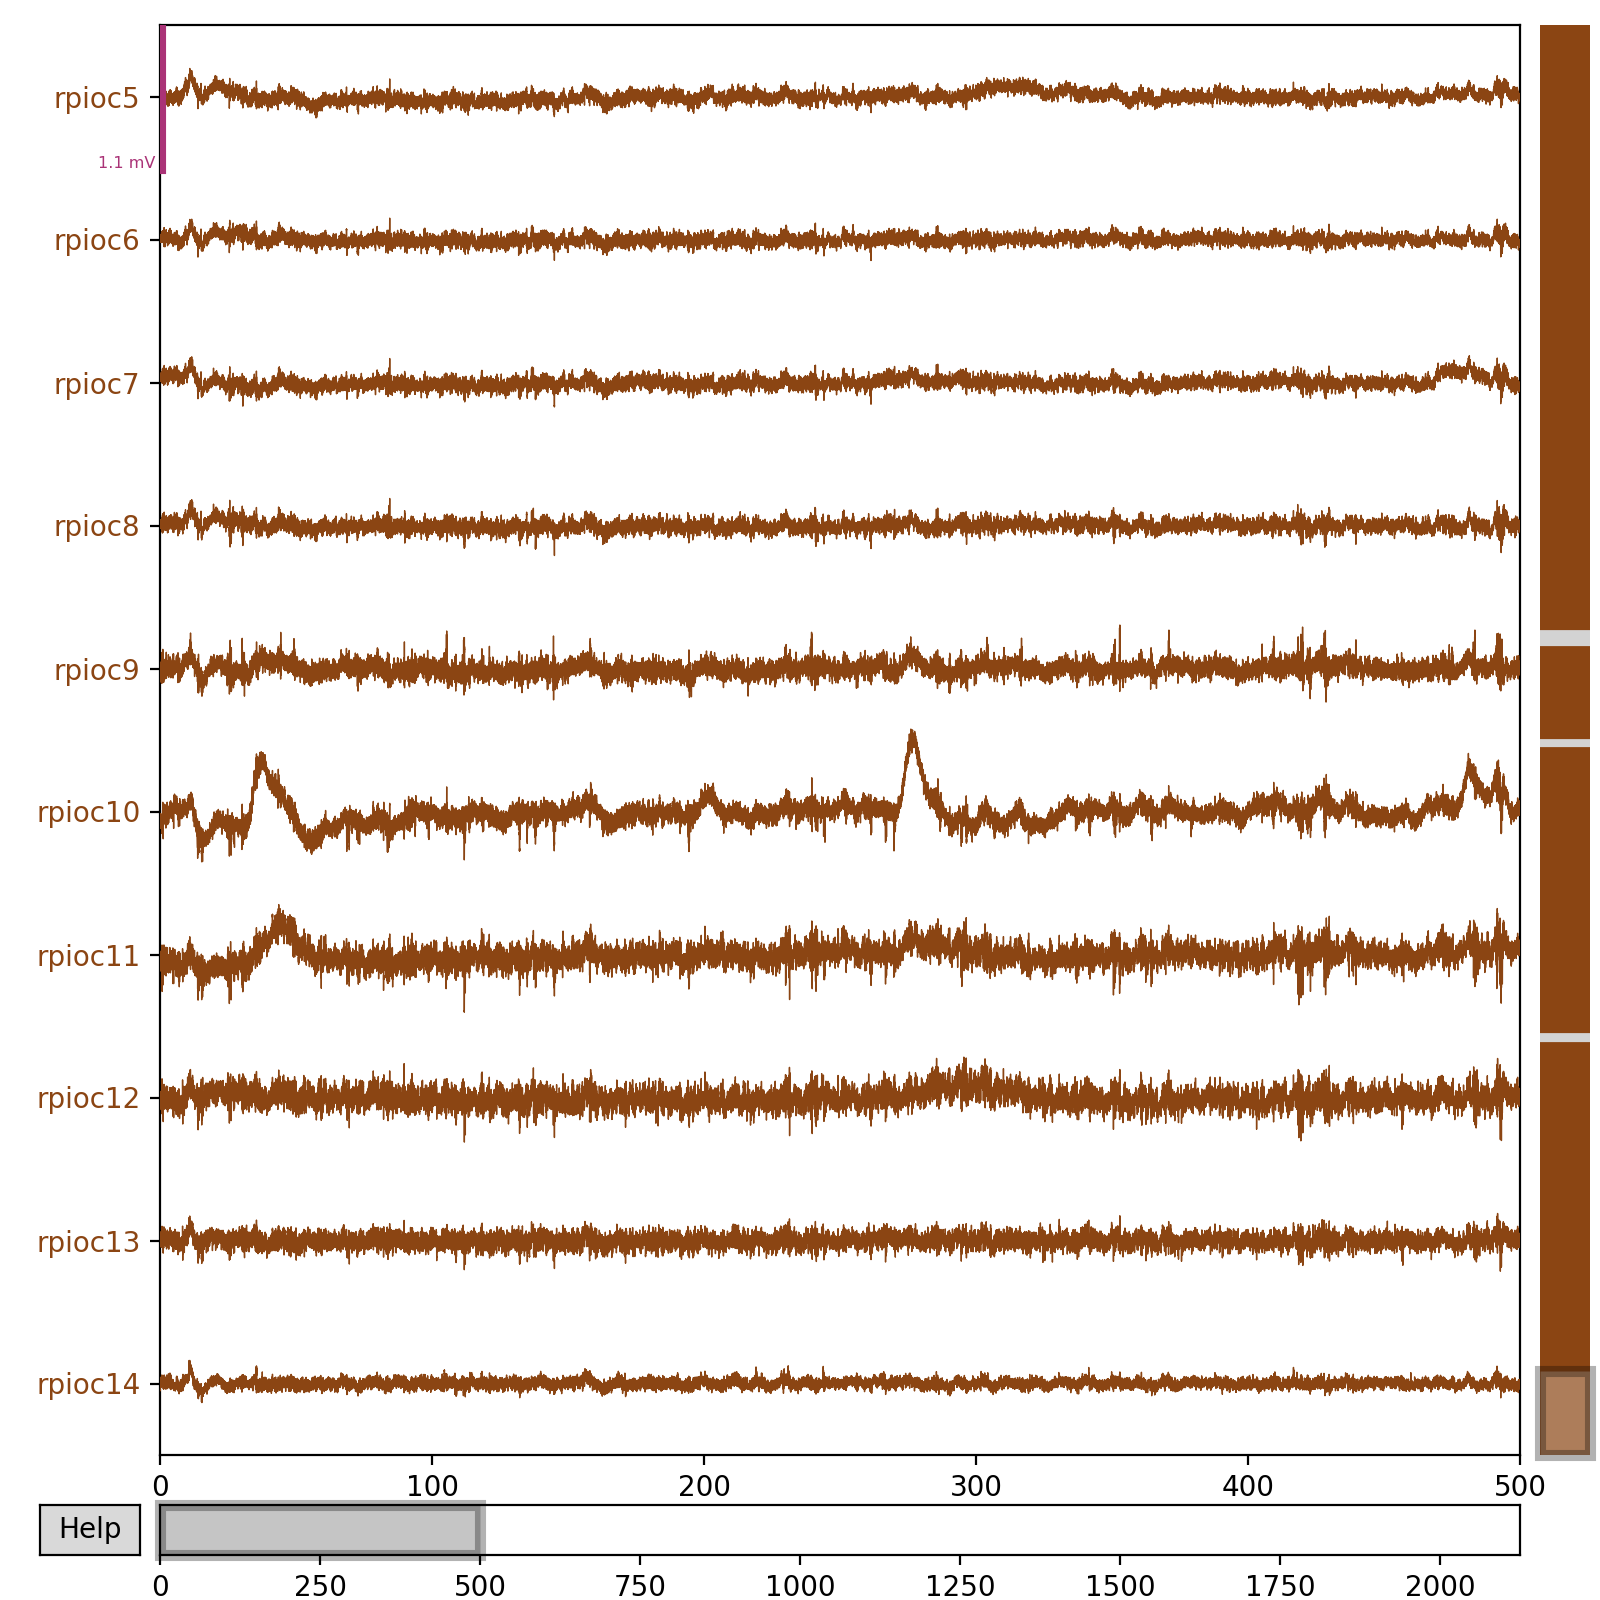

<IPython.core.display.Javascript object>


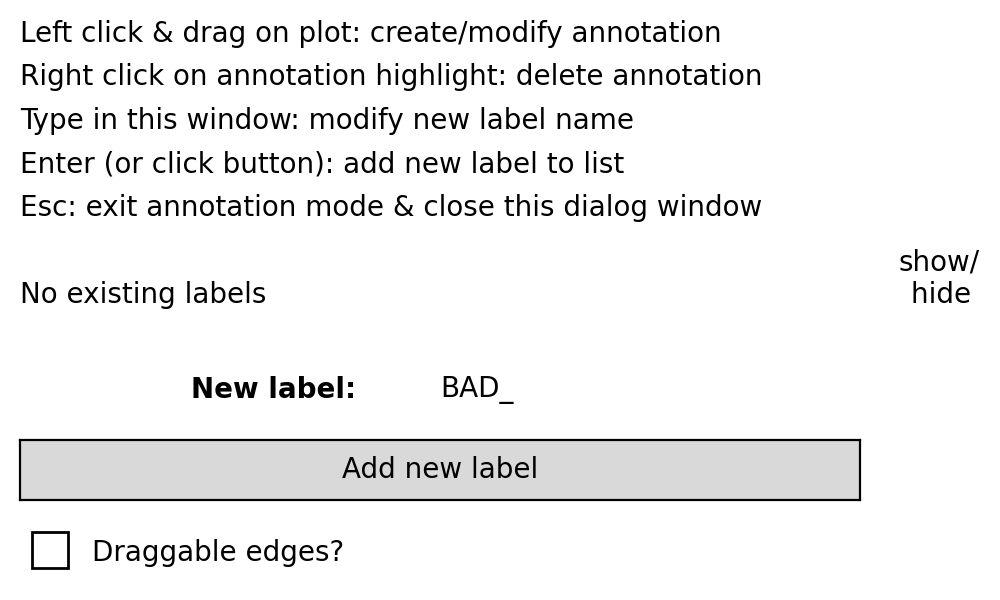

In [41]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads']

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

<IPython.core.display.Javascript object>


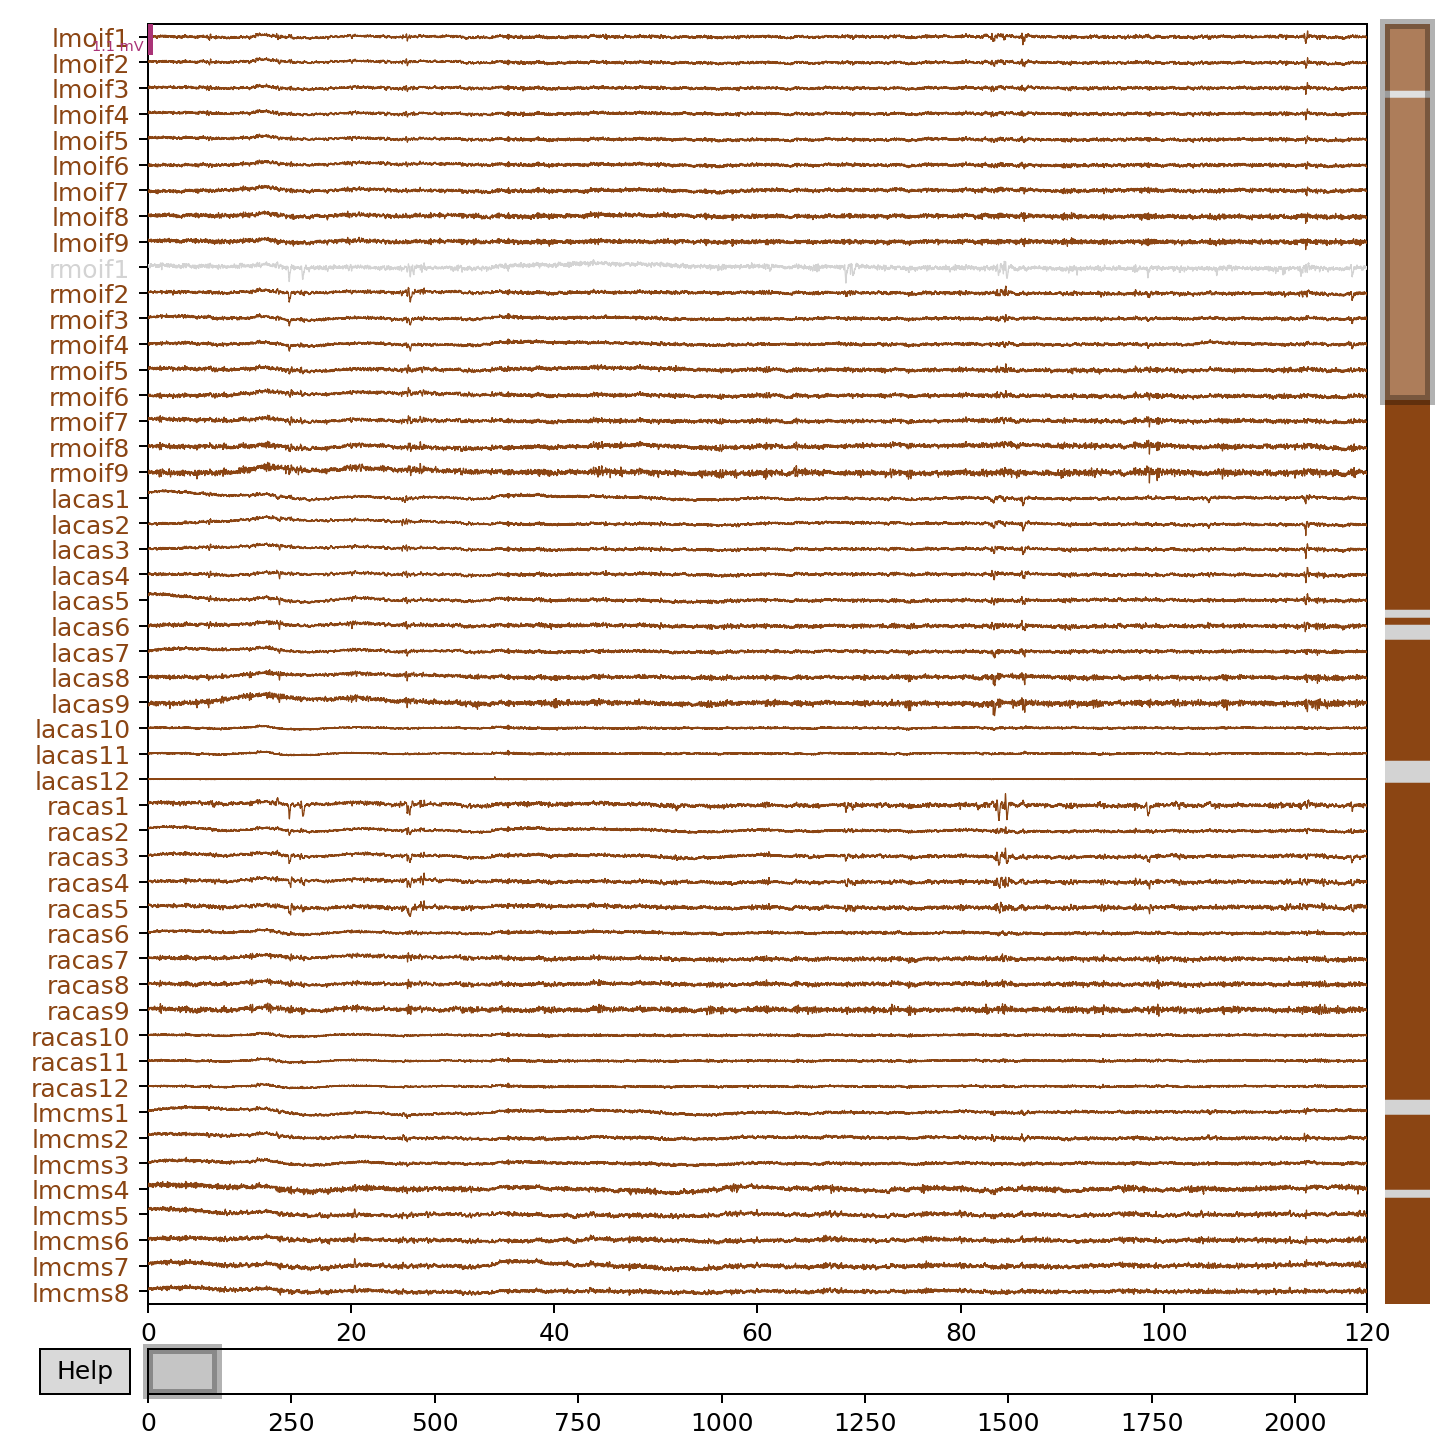

<IPython.core.display.Javascript object>


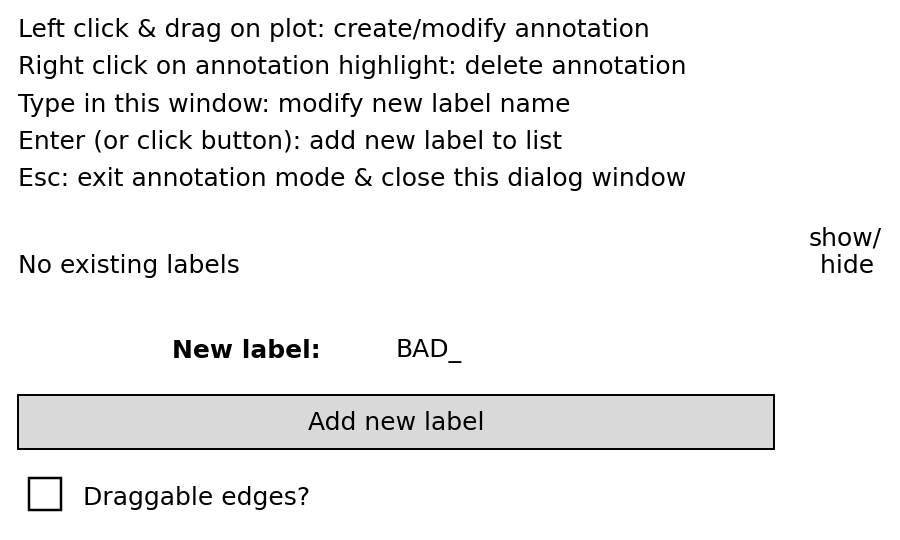

In [53]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [46]:
mne_data.info['bads'] 

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

In [47]:
#set bad channel info 
ms019_bad_ch = ['ragit9','lsppc11','lsppc12','rsppc12']


In [49]:
len(ms019_bad_ch)

4

In [54]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms019_bad_ch 

In [55]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 4 items (ragit9, lsppc11, lsppc12, rsppc12)
 ch_names: lmoif1, lmoif2, lmoif3, lmoif4, lmoif5, lmoif6, lmoif7, lmoif8, ...
 chs: 170 sEEG
 custom_ref_applied: False
 dig: 170 items (170 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:46:21 UTC
 nchan: 170
 projs: []
 sfreq: 512.0 Hz
>

In [56]:
mne_data.info['bads'] #more sanity checking

['ragit9', 'lsppc11', 'lsppc12', 'rsppc12']

### Rereference data to wm electrodes

In [57]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=ms019_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [58]:
oob_channels

['lacas11',
 'lacas12',
 'lhpit10',
 'liito2',
 'liito7',
 'liito8',
 'lmcms10',
 'lmcms8',
 'lmcms9',
 'lsppc11',
 'lsppc12',
 'racas11',
 'racas12',
 'ragit10',
 'rhpit10',
 'riito7',
 'riito8',
 'rmcms10',
 'rmcms8',
 'rmcms9',
 'rpioc14',
 'rsppc11',
 'rsppc12']

In [59]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms019_bad_ch = ms019_bad_ch + oob_channels
ms019_bad_ch = list(np.unique(ms019_bad_ch))
mne_data.info['bads'] = ms019_bad_ch

In [62]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'lhpit10',
 'liito2',
 'liito7',
 'liito8',
 'lmcms10',
 'lmcms8',
 'lmcms9',
 'lsppc11',
 'lsppc12',
 'racas11',
 'racas12',
 'ragit10',
 'ragit9',
 'rhpit10',
 'riito7',
 'riito8',
 'rmcms10',
 'rmcms8',
 'rmcms9',
 'rpioc14',
 'rsppc11',
 'rsppc12']

In [63]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [64]:
mne_data_reref

<RawEDF | MS019_SWB.edf, 138 x 1088000 (2125.0 s), ~1.12 GB, data loaded>

### Save cleaned continuous data

In [74]:
mne_data.save(f'{neural_dir}/MS019/lfp_data.fif',overwrite=True)

In [65]:
mne_data_reref.save(f'{neural_dir}/MS019/wm_ref_ieeg.fif',overwrite=True)